In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from keras.preprocessing import image as keras_image
from PIL import Image
import IPython.display as display

base_image_path = '/content/base_image.jpg'
style_reference_image_path = '/content/style_image.png'
result_prefix = "image_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


# Dimensions of the generated picture.
width, height = keras.utils.load_img('/content/base_image.jpg').size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

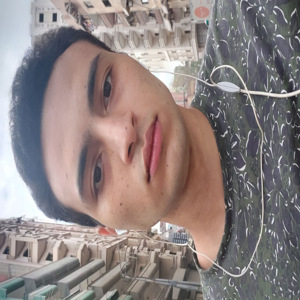

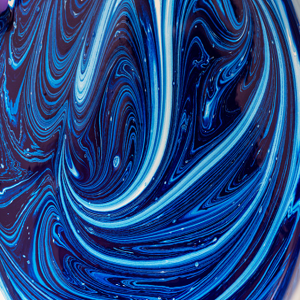

In [2]:
base_image = Image.open(base_image_path)
base_image = base_image.resize((300, 300))

style_reference_image = Image.open(style_reference_image_path)
style_reference_image = style_reference_image.resize((300, 300))

display.display(base_image)
display.display(style_reference_image)


In [3]:
from StyleTransferFunctions import *

In [4]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [5]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [6]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [7]:
from keras.preprocessing import image as keras_image

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=17956.64
Iteration 200: loss=13533.17
Iteration 300: loss=11548.48
Iteration 400: loss=10356.47
Iteration 500: loss=9527.74
Iteration 600: loss=8903.74
Iteration 700: loss=8407.49
Iteration 800: loss=8000.53
Iteration 900: loss=7658.92
Iteration 1000: loss=7367.03
Iteration 1100: loss=7114.92
Iteration 1200: loss=6895.63
Iteration 1300: loss=6702.38
Iteration 1400: loss=6531.45
Iteration 1500: loss=6379.32
Iteration 1600: loss=6242.98
Iteration 1700: loss=6120.07
Iteration 1800: loss=6009.06
Iteration 1900: loss=5908.16
Iteration 2000: loss=5816.05
Iteration 2100: loss=5731.84
Iteration 2200: loss=5654.82
Iteration 2300: loss=5584.21
Iteration 2400: loss=5519.36
Iteration 2500: loss=5459.57
Iteration 2600: loss=5404.31
Iteration 2700: loss=5353.06
Iteration 2800: loss=5305.53
Iteration 2900: loss=5261.33
Iteration 3000: loss=5220.13
Iteration 3100: loss=5181.69
Iteration 3200: loss=5145.83
Iteration 3300: loss=5112.31
Iteration 3400: loss=5080.95
Iteration 3500: los

In [8]:
from keras.models import Model
import json
import tensorflow as tf
from tensorflow.keras.layers import Input

# Assuming `content_image` and `style_image` are your input tensors

content_input = Input(tensor=base_image)
style_input = Input(tensor=combination_image)

# Define the model architecture and get the combined model
model = Model(inputs=[content_input], outputs=[style_input])

# Save the model's weights and architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

# Save the input image paths for reference
input_paths = {'content_image': base_image_path, 'style_image': style_reference_image_path}
with open('input_paths.json', 'w') as f:
    json.dump(input_paths, f)
